Produits dérivés



In [1]:
# Importation des packages 

import math
#import simpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats
from itertools import chain
from scipy.stats import norm
import matplotlib.pyplot as plt



In [2]:
# Paramètres

r = 0.04
y = 0.02
sigma = 0.3
S = 100
K = [90, 100, 110]
T = 3 / 12
n = 1000

 Question 1 méthode Binomial

In [3]:
#impleantation up et down

delta = T / n
u = np.exp(sigma * np.sqrt(delta))
d = 1 / u
p = (np.exp((r-y) * delta) - d) / (u - d)

In [4]:
#Implantation de la methode crr

def put_binomial(S, T, y, K, r, sigma, n):
    
    delta = T / n
    u = np.exp(sigma * np.sqrt(delta))
    d = 1 / u
    p = (np.exp((r-y) * delta) - d) / (u - d)

    # Construction de l'arbre
    price_tree = np.zeros((n+1, n+1))
    option_tree = np.zeros((n+1, n+1))

    price_tree[0, 0] = S
    for i in range(1, n+1):
        price_tree[i, 0] = price_tree[i-1, 0] * u
        for j in range(1, i+1):
            price_tree[i, j] = price_tree[i-1, j-1] * d

    # Calcul des valeurs de l'option à l'expiration
    for j in range(1,n+1):
        option_tree[n, j] = max(K - price_tree[n, j], 0)

    # Remontée de l'arbre
    for i in range(n-1, -1, -1):
        for j in range(i+1):
            option_tree[i, j] = np.exp(-r * delta) * (p * option_tree[i+1, j] + (1-p) * option_tree[i+1, j+1])

    put_price = option_tree[0, 0]

    return put_price


        


In [5]:
# Calcul theta, delta, gamma

def delta(S, u, d, T, y, K, r, sigma, n):
    deltas = (put_binomial(S*u, T, y, K, r, sigma, n) - put_binomial(S*d, T, y, K, r, sigma, n)) / (S * (u - d))
    return deltas


def gamma(S, u, d, T, y, K, r, sigma, n):
    Suu = S*u**2
    Sdd = S*d**2
    Sud = S*u*d
    gammas = (put_binomial(Suu, T, y, K, r, sigma, n) - 2*put_binomial(Sud, T, y, K, r, sigma, n) + put_binomial(Sdd, T, y, K, r, sigma, n)) / ((u - d)*S)
    return gammas


def theta(S, T, y, K, r, sigma, n):
    dt = T/n
    thetas = (put_binomial(S, T - dt, y, K, r, sigma, n) - put_binomial(S, T, y, K, r, sigma, n)) / dt
    return thetas  
        

In [6]:
# Initialisation des matrices de résultats

put_bin = []
deltas_bin = []
gammas_bin = []
thetas_bin = []


In [7]:

# Résultats obtenus arbre binomial

for k_val in K:
    put_price = put_binomial(S, T, y, k_val, r, sigma, n)
    delta_val = delta(S, u, d, T, y, k_val, r, sigma, n)
    gamma_val = gamma(S, u, d, T, y, k_val, r, sigma, n)
    theta_val = theta(S, T, y, k_val, r, sigma, n)

    put_bin.append(put_price)
    deltas_bin.append(delta_val)
    gammas_bin.append(gamma_val)
    thetas_bin.append(theta_val)
    
print("Put prices avec approche binomiale:", put_bin)
print("Deltas avec approche binomiale:", deltas_bin)
print("Gammas avec approche binomiale:", gammas_bin)
print("Thetas avec approche binomiale:", thetas_bin)


Put prices avec approche binomiale: [1.8951847327368816, 5.6875498544579, 12.024130672234131]
Deltas avec approche binomiale: [-0.20780887229821665, -0.4545681231610872, -0.6972964156494766]
Gammas avec approche binomiale: [0.01609960426437384, 0.020639927668963356, 0.015232188286158018]
Thetas avec approche binomiale: [-7.934605467540656, -10.702298783172637, -8.301769150719451]


Vérification de l'EDP avec la méthode binomial

In [8]:


#Implementation de la solution des PDE avec Crank-Nicolson method

def Crank_price( S, K, r, T, sigma, S_max, M, n):

    price = 0
    omega = 1.2

    dt = T / n
    ds = S_max / M

    I = np.arange(0, M+1)
    J = np.arange(0, n+1)

    old_val = np.zeros(M-1)
    new_val = np.zeros(M-1)

    # Boundary and final conditions
    payoff = np.maximum(K - I[1:M] * ds, 0)
    old_layer = payoff
    bound_val = K * np.exp(-r * (n+1 - J) * dt)

    # Calculating elements of M
    alpha = 0.25 * dt * (sigma**2 * (I**2) - r * I)
    alpha = alpha[1:]
    beta = -dt * 0.5 * (sigma**2 * (I**2) + r)
    beta = beta[1:]
    gamma = 0.25 * dt * (sigma**2 * (I**2) + r * I)
    gamma = gamma[1:]

    M2 = np.diag(1+beta[:M-1]) + np.diag(alpha[1:M-1], k=-1) + np.diag(gamma[:M-2], k=1)
    b = np.zeros(M-1)

    for j in range(n-1, -1, -1):
        b[0] = alpha[0] * (bound_val[j] + bound_val[j+1])
        rhs = M2 @ old_layer + b
        old_val = old_layer
        error = 1000000
        while error > tol:
            new_val[0] = np.maximum(payoff[0], old_val[0] + (omega/(1-beta[0]))*(rhs[0] - (1-beta[0])*old_val[0] + gamma[0] * old_val[1]))
            for k in range(1, M-2):
                new_val[k] = np.maximum(payoff[k], old_val[k] + (omega / (1 - beta[k])) * (
                            rhs[k] - (1 - beta[k]) * old_val[k] + alpha[k] * new_val[k-1] + gamma[k] * old_val[k+1]))
            new_val[M-2] = np.maximum(payoff[M-2], old_val[M-2] + (omega / (1 - beta[M-2])) * (
                    rhs[M-2] - (1 - beta[M-2]) * old_val[M-2] + alpha[M-2] * new_val[M-3]))
            error = np.linalg.norm(new_val - old_val)
            old_val = new_val
        old_layer = new_val


    prices_t0 = np.concatenate(([bound_val[0]], old_layer, [0]))
    idown = int(np.floor(S / ds))
    iup = int(np.ceil(S / ds))
    #print(idown)
    #print(iup)

    if idown == iup:
        price = prices_t0[idown]
    else:
        price = prices_t0[idown] + ((iup - (S / ds)) / (iup - idown)) * (prices_t0[iup] - prices_t0[idown])

    print('EDP Price with the Crank-Nicolson method is:', price)
    return price

# compute
tol = 0.05
EDP_price = []


for K_val in K:
    EDP = Crank_price(S, K_val, r, T, sigma, S_max=1000, M=100, n=1000)
    EDP_price.append(EDP)
    
   
if len(put_bin) == len(EDP_price):
    for i in range(len(put_bin)):
        if abs(put_bin[i] - EDP_price[i]) < tol*EDP_price[i]:
            print("L'EDP est vérifiée numériquement.")
        else:
            print("L'EDP n'est pas vérifiée numériquement.")
else:
    print("Lengths of put_bin and EDP_price do not match.")

EDP Price with the Crank-Nicolson method is: 1.9595042104058107
EDP Price with the Crank-Nicolson method is: 5.681172737951709
EDP Price with the Crank-Nicolson method is: 12.035432089581903
L'EDP est vérifiée numériquement.
L'EDP est vérifiée numériquement.
L'EDP est vérifiée numériquement.


Question 2 Methode Trinomial

In [9]:
#Implantation u , d, m

dt = T / n
u_t = math.exp(sigma * math.sqrt(3 * dt))
d_t = math.exp(-sigma * math.sqrt(3 * dt))
qu_t = (math.sqrt(dt / (12 * sigma ** 2)) * (r - y - (sigma ** 2 * 0.5))) + 1 / 6
qd_t = -(math.sqrt(dt / (12 * sigma ** 2)) * (r - y - (sigma ** 2 * 0.5))) + 1 / 6
qm_t = 2 / 3


In [10]:
# implantation modele trinomial

def put_trin(S, K, r, y, sigma, T, n):
    
    dt = T / n
    u_t = math.exp(sigma * math.sqrt(3 * dt))
    d_t = math.exp(-sigma * math.sqrt(3 * dt))
    m = 1
    qu_t = (math.sqrt(dt / (12 * sigma ** 2)) * (r - y - (sigma ** 2 * 0.5))) + 1 / 6
    qd_t = -(math.sqrt(dt / (12 * sigma ** 2)) * (r - y - (sigma ** 2 * 0.5))) + 1 / 6
    qm_t = 2 / 3

    STs = [np.array([S])]

    for i in range(n):
        prev_nodes = STs[-1]
        ST = np.concatenate((prev_nodes * u_t, [prev_nodes[-1] * m, prev_nodes[-1] * d_t]))
        STs.append(ST)

    payoffs = np.maximum(K - STs[-1], 0)

    for i in reversed(range(n)):
        payoffs = (payoffs[:-2] * qu_t + payoffs[1:-1] * qm_t + payoffs[2:] * qd_t) * math.exp(-r * dt)
        payoffs = np.maximum(K - STs[i], payoffs)

    return payoffs[0]

  

In [11]:
# Initialisation des matrices de résultats

put = []
deltas_trin = []
gammas_trin = []
thetas_trin = []

In [12]:
# Calcul theta, delta, gamma

def delta(S, u, d, T, y, K, r, sigma, n):
    deltas = (put_trin(S*u, K, r, y, sigma, T, n) - put_trin(S*d, K, r, y, sigma, T, n)) / (S * (u - d))
    return deltas


def gamma(S, u, d, T, y, K, r, sigma, n):
    Suu = S*u**2
    Sdd = S*d**2
    Sud = S*u*d
    gammas = (put_trin(Suu, K, r, y, sigma, T, n) - 2*put_trin(Sud, K, r, y, sigma, T, n) + put_trin(Sdd, K, r, y, sigma, T, n)) / ((u - d)*S)
    return gammas


def theta(S, T, y, K, r, sigma, n):
    dt = T/n
    thetas = (put_trin(S, K, r, y, sigma, T-dt, n) - put_trin(S, K, r, y, sigma, T, n)) / dt
    return thetas  
        

In [13]:

for K_val in K:
    payoffs = put_trin(S, K_val, r, y, sigma, T, n)
    delta_tri = delta(S, u_t, d_t, T, y, K_val, r, sigma, n)
    gamma_tri = gamma(S, u_t, d_t, T, y, K_val, r, sigma, n)
    theta_tri = theta(S, T, y, K_val, r, sigma, n)
    
    put.append(payoffs)
    deltas_trin.append(delta_tri)
    gammas_trin.append(gamma_tri)
    thetas_trin.append(theta_tri)
    
print("Put prices:", put)
print("Deltas:", deltas_trin)
print("Gammas:", gammas_trin)
print("Thetas:", thetas_trin)


    


Put prices: [1.9050406349070597, 5.727769716295573, 12.14324856773622]
Deltas: [-0.2091224451853903, -0.45910549732844436, -0.7082134412794083]
Gammas: [0.028135600231135722, 0.03642125402734942, 0.02767235215539971]
Thetas: [-8.261996152672424, -10.90188238570633, -8.904286287823027]


Vérification de l'EDP avec la méthode trinomial

In [14]:
# vérification EDP

tol = 0.05
EDP_price = []

for K_val in K:
    EDP = Crank_price(S, K_val, r, T, sigma, S_max=1000, M=100, n=1000)
    EDP_price.append(EDP)
    
if len(put) == len(EDP_price):
    for i in range(len(put)):
        if abs(put[i] - EDP_price[i]) < tol*EDP_price[i]:
            print("L'EDP est vérifiée numériquement.")
        else:
            print("L'EDP n'est pas vérifiée numériquement.")
else:
    print("Lengths of put_bin and EDP_price do not match.")

EDP Price with the Crank-Nicolson method is: 1.9595042104058107
EDP Price with the Crank-Nicolson method is: 5.681172737951709
EDP Price with the Crank-Nicolson method is: 12.035432089581903
L'EDP est vérifiée numériquement.
L'EDP est vérifiée numériquement.
L'EDP est vérifiée numériquement.


#3 Carr, Jarrow and Mynemi model without dividend

In [15]:
def d1(S, K, r, sigma, T):
    return (math.log(S/(K)) + (r + (sigma**2)/2)*(T))/(sigma*math.sqrt(T))

def d2(S, K, r, sigma, T):
    return d1(S, K, r, sigma, T) - sigma*math.sqrt(T)

def P(S, T, K):
    Bt = B_t(S, T,  K)
    p = european_put(S, T, K)
    integral = integrate(S, T, K, Bt)
    return p + integral

def european_put(S, T, K):
    d1_val = d1(S, K, r, sigma, T)
    d2_val = d2(S, K, r, sigma, T)
    return K*math.exp(-r*T)*norm.cdf(-d2_val) - S*norm.cdf(-d1_val)

def B_t(S, T, K):
    tau = T
    m = math.log(K) + (r + (sigma**2)/2)*tau - sigma*math.sqrt(tau)
    return math.exp(m)

def integrand(S, T, K, Bt, t):
    tau = T - t
    _d2_val = (math.log(Bt/S) - (r-0.5*sigma**2)*tau) / (sigma*math.sqrt(tau))
    return r*K*math.exp(-r*t)*norm.cdf(_d2_val)

def integrate(S, T, K, Bt):
    num_intervals = 1000
    dt = T/num_intervals
    t_values = [i*dt for i in range(num_intervals+1)]
    integral = 0
    for i in range(num_intervals):
        integral += dt*integrand(S, T, K, Bt, t_values[i])
    return integral


In [16]:
# Résultats obtenus CJM

puts = []
for K_val in K:
    puts.append(P(S, T, K_val))

for i in range(len(K)):
    print(f"Put américain de lapproche CJM' avec K={K[i]}: {puts[i]}")

Put américain de lapproche CJM' avec K=90: 1.8117056583218638
Put américain de lapproche CJM' avec K=100: 5.567696551263886
Put américain de lapproche CJM' avec K=110: 12.05936632939779


Question 4 Graphiques de convergence

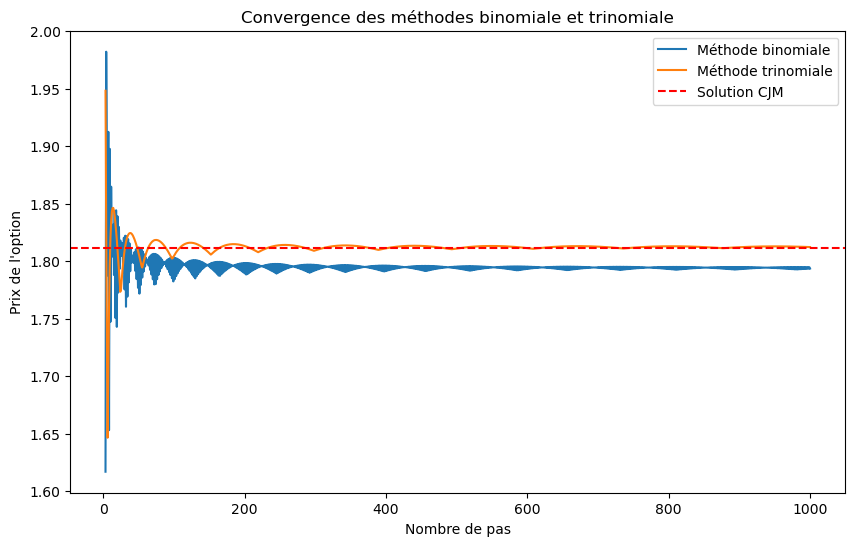

In [17]:
# Calcul des prix des puts pour différents nombres de pas

N_steps = np.arange(3, 1001)
binomial_prices = []
trinomial_prices = []


for N in N_steps:
    y = 0
    # Calcul du prix selon la méthode binomiale
    binomial_price = put_binomial(S, T, y, 90, r, sigma, N)
    binomial_prices.append(binomial_price) 
    
    # Calcul du prix selon la méthode trinomiale
    trinomial_price = put_trin(S, 90, r, y, sigma, T, N)
    trinomial_prices.append(trinomial_price)
    cjm_solution = P(S, T, 90)
# Graphique de la convergence des méthodes binomiale et trinomiale
plt.figure(figsize=(10, 6))
plt.plot(N_steps, binomial_prices, label='Méthode binomiale')
plt.plot(N_steps, trinomial_prices, label='Méthode trinomiale')
plt.axhline(y=cjm_solution, color='r', linestyle='--', label='Solution CJM')
plt.xlabel('Nombre de pas')
plt.ylabel('Prix de l\'option')
plt.title('Convergence des méthodes binomiale et trinomiale')
plt.legend()
plt.show()

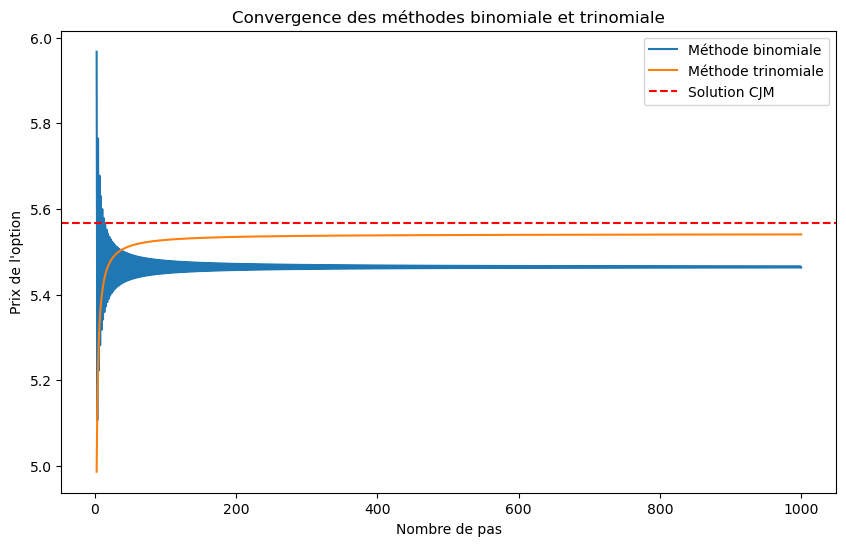

In [18]:
# Calcul des prix des puts pour différents nombres de pas
N_steps = np.arange(3, 1001)
binomial_prices = []
trinomial_prices = []


for N in N_steps:
    y = 0
    # Calcul du prix selon la méthode binomiale
    binomial_price = put_binomial(S, T, y, 100, r, sigma, N)
    binomial_prices.append(binomial_price) 
    
    # Calcul du prix selon la méthode trinomiale
    trinomial_price = put_trin(S, 100, r, y, sigma, T, N)
    trinomial_prices.append(trinomial_price)
    cjm_solution = P(S, T, 100)
# Graphique de la convergence des méthodes binomiale et trinomiale
plt.figure(figsize=(10, 6))
plt.plot(N_steps, binomial_prices, label='Méthode binomiale')
plt.plot(N_steps, trinomial_prices, label='Méthode trinomiale')
plt.axhline(y=cjm_solution, color='r', linestyle='--', label='Solution CJM')
plt.xlabel('Nombre de pas')
plt.ylabel('Prix de l\'option')
plt.title('Convergence des méthodes binomiale et trinomiale')
plt.legend()
plt.show()

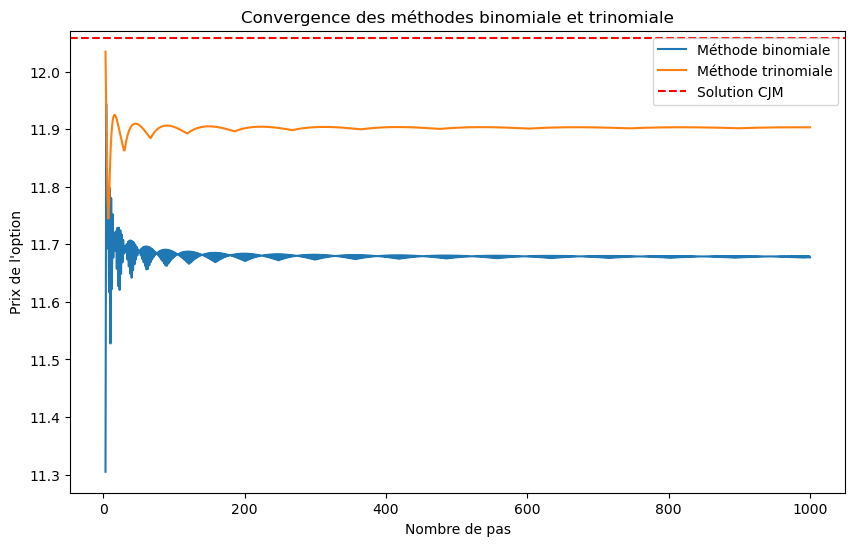

In [19]:
N_steps = np.arange(3, 1001)
binomial_prices = []
trinomial_prices = []


for N in N_steps:
    y = 0
    # Calcul du prix selon la méthode binomiale
    binomial_price = put_binomial(S, T, y, 110, r, sigma, N)
    binomial_prices.append(binomial_price) 
    
    # Calcul du prix selon la méthode trinomiale
    trinomial_price = put_trin(S, 110, r, y, sigma, T, N)
    trinomial_prices.append(trinomial_price)
    cjm_solution = P(S, T, 110)
# Graphique de la convergence des méthodes binomiale et trinomiale
plt.figure(figsize=(10, 6))
plt.plot(N_steps, binomial_prices, label='Méthode binomiale')
plt.plot(N_steps, trinomial_prices, label='Méthode trinomiale')
plt.axhline(y=cjm_solution, color='r', linestyle='--', label='Solution CJM')
plt.xlabel('Nombre de pas')
plt.ylabel('Prix de l\'option')
plt.title('Convergence des méthodes binomiale et trinomiale')
plt.legend()
plt.show()

Question 5

In [20]:
#POUR N=2000

def d1(S, K, r, sigma, T):
    return (math.log(S/(K)) + (r + (sigma**2)/2)*(T))/(sigma*math.sqrt(T))

def d2(S, K, r, sigma, T):
    return d1(S, K, r, sigma, T) - sigma*math.sqrt(T)

def P(S, T, K):
    Bt = B_t(S, T,  K)
    p = european_put(S, T, K)
    integral = integrate(S, T, K, Bt)
    return p + integral

def european_put(S, T, K):
    d1_val = d1(S, K, r, sigma, T)
    d2_val = d2(S, K, r, sigma, T)
    return K*math.exp(-r*T)*norm.cdf(-d2_val) - S*norm.cdf(-d1_val)

def B_t(S, T, K):
    tau = T
    m = math.log(K) + (r + (sigma**2)/2)*tau - sigma*math.sqrt(tau)
    return math.exp(m)

def integrand(S, T, K, Bt, t):
    tau = T - t
    _d2_val = (math.log(Bt/S) - (r-0.5*sigma**2)*tau) / (sigma*math.sqrt(tau))
    return r*K*math.exp(-r*t)*norm.cdf(_d2_val)

def integrate(S, T, K, Bt):
    num_intervals = 2000
    dt = T/num_intervals
    t_values = [i*dt for i in range(num_intervals+1)]
    integral = 0
    for i in range(num_intervals):
        integral += dt*integrand(S, T, K, Bt, t_values[i])
    return integral


In [21]:
# Résultats obtenus CJM à n =2000

puts = []
for K_val in K:
    puts.append(P(S, T, K_val))

for i in range(len(K)):
    print(f"Put américain de lapproche CJM' avec K={K[i]}: {puts[i]}")

Put américain de lapproche CJM' avec K=90: 1.811692089367994
Put américain de lapproche CJM' avec K=100: 5.567647127975809
Put américain de lapproche CJM' avec K=110: 12.059252189992074


In [22]:
Différence = []

# Calcul de la différence de valeur pour chacun des trois puts
for K_val in K:
    y = 0
    n=200
    diff_put = P(S, T, K_val) - put_trin(S, K_val, r, y, sigma, T, n)
    Différence.append(diff_put)
    
# Affichage des différences de valeur
print("Différence pour le put 1:", Différence[0])
print("Différence pour le put 2:", Différence[1])
print("Différence pour le put 3:", Différence[2])
 
 

Différence pour le put 1: -0.0013789101100083467
Différence pour le put 2: 0.0330542292927829
Différence pour le put 3: 0.15758082450471278


In [23]:
# Ajustement des estimations des puts avec dividendes faites par le modèle trinomial avec 200 pas

y=0.02
n = 200
adjusted_put1 = put_trin(S, 90, r, y, sigma, T, n) + Différence[0]
adjusted_put2 = put_trin(S, 100, r, y, sigma, T, n) + Différence[1]
adjusted_put3 = put_trin(S, 110, r, y, sigma, T, n) + Différence[2]

# Affichage des résultats

print("Put ajusté 1 (trinomial):", adjusted_put1)
print("Put ajusté 2 (trinomial):", adjusted_put2)
print("Put ajusté 3 (trinomial):", adjusted_put3)

Put ajusté 1 (trinomial): 1.904692662145633
Put ajusté 2 (trinomial): 5.755053296145846
Put ajusté 3 (trinomial): 12.299380447175103


In [24]:
# Calcul du put avec dividendes par le modèle binomial avec 2000 pas 

n = 2000
bin_2000 =[] 
for K_val in K:
    y=0.02
    prices_binomial = put_binomial(S, T, y, K_val, r, sigma, n)
    bin_2000.append(prices_binomial)

# Affichage des résultats
print("Put (binomial a 2000 pas):", bin_2000)

Put (binomial a 2000 pas): [1.8958929709189087, 5.688291855930652, 12.025271015254727]
